In [1]:
import pandas as pd
from sqlalchemy import create_engine
import os
import seaborn as sns
import matplotlib as plt

# Configurations matching docker
DB_CONFIG = {
    'user': os.getenv('DB_USER', 'egg_user'),
    'password': os.getenv('DB_PASSWORD', 'egg_pass'),
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', 5432),
    'database': os.getenv('DB_NAME', 'egg_prices')
}

# Clean connection string
conn_string = (
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}"
    f"@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

# Creating Dataframe and CSV file for analysis
engine = create_engine(conn_string)
df = pd.read_sql("SELECT * FROM economic_data", engine)
df.to_csv('data/egg_price_drivers.csv')

In [2]:
df.head()

,date,flu_outbreak_count,flu_birds_affected,egg_price,corn_price,month,quarter
0,2019-01-01,0.0,0.0,1.554,166.846241,1,1
1,2019-02-01,0.0,0.0,1.557,169.656283,2,1
2,2019-03-01,0.0,0.0,1.544,166.321332,3,1
3,2019-04-01,0.0,0.0,1.463,161.653387,4,2
4,2019-05-01,0.0,0.0,1.362,171.180154,5,2


### Exploratory Analysis

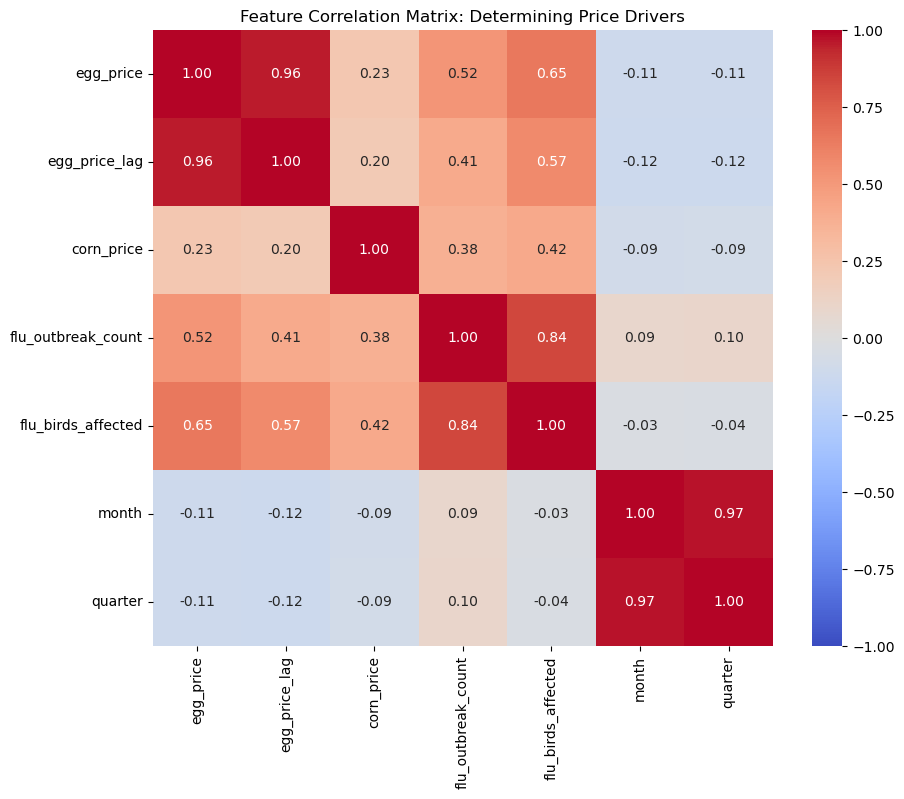

In [9]:
# Create Market Memory (Lagged Price): "What was the price last month?"
df['egg_price_lag'] = df['egg_price'].shift(1) # shifts the price down by 1 row
features = [
    'egg_price',
    'egg_price_lag',
    'corn_price',
    'flu_outbreak_count',
    'flu_birds_affected',
    'month',
    'quarter'
]
eda_df = df[features].dropna() # drop first row from shift

corr_matrix = eda_df.corr()

fig = plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            vmin=-1, vmax=1)

plt.title('Feature Correlation Matrix: Determining Price Drivers')
plt.show()
